In [1]:
####
# Original network adapted from karpathy
# minesh.mathew@gmail.com
# modified version of text generation example in keras;
# trained in a many-to-many fashion using a time distributed dense layer

# 20210803:  Borghetti modified for new NVIDIA GPU architectures (30X0) and repaired nonworking code elements

####
from __future__ import print_function


from matplotlib import pyplot as plt
from matplotlib import pyplot
import matplotlib as mptl
import pylab

import tensorflow as tf
from tensorflow import keras as keras



#import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
# from keras.layers import LSTM, TimeDistributedDense, SimpleRNN  #DEPRECATED TimeDistributedDense
from keras.layers import LSTM, TimeDistributed, SimpleRNN
from keras.utils.data_utils import get_file
import numpy as np
from time import sleep
import random
import sys
import os
import pickle
import gzip
from sklearn.metrics import confusion_matrix
import itertools
import h5py

#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model

In [2]:
print("Tensorflow version: ", tf.__version__)
print("Tensorflow devices: ", tf.config.list_physical_devices("GPU"))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

Tensorflow version:  2.6.0
Tensorflow devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# ---------------------- GENERIC UTILITIES --------------------------
def plot_confusion_matrix(cm, class_labels, title='Confusion matrix',
                          filename = 'Confusion_Matrix.png', cmap=plt.cm.Blues):
    """
    Plot a confusion matrix
    :param cm: a confusion matrix generated by sklearn.metrics.confusion_matrix
    :param class_labels: set of text labels
    :param title: title of figure
    :param cmap: color map for the confusion matrix
    :return:
    """
    class_count = len(class_labels)
    fig = plt.figure(title)
    fig.set_size_inches(10, 8)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(class_count+1)
#     tick_marks = np.arange(class_count)
#     plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    plt.xlim((tick_marks[0]-0.5, tick_marks[-1]-0.5))
    plt.ylim((tick_marks[0]-0.5, tick_marks[-1]-0.5))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%0.2f%%' % (cm[i, j]*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(filename, dpi=100)
    np.set_printoptions(precision=2)
    plt.show(block=False)
    
# ---------------- MODEL FILE I/O ---------------------------
def save_model(model, save_dir=os.path.join(os.getcwd(), 'saved_models'),
               model_file_name='keras_cifar10_trained_model.h5'):
    """
    Save model and current weights
    :param model: Keras model
    :param save_dir: path name to save directory
    :param model_file_name: filename for saved model
    :return: nothing
    """
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_file_name)
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)


def load_model(save_dir, model_file_name):
    # Load model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_file_name)
    model = keras.models.load_model(model_path)
    print('Loaded trained model from %s ' % model_path)
    return model

## STEP 1: Student Architecture Design 
Your goal in this step is to design and document your proposed model.
#### a) Design the model
Your model has a different ML task than Karpathy’s – you need to determine from which text a sequence of characters most likely came from.  Your input observation will be a string of text (40 characters) drawn from the training text.  Your output will be a class ID (0_bible.txt; 1_nietzsche.text; 2_shakespeare.txt; 3_warpeace.txt;).  You can provide a class ID for each character in the input sequence, but you must provide an overall class ID (0, 1, 2, or 3) for the whole input sequence.  You could use one-hot encoding here.

#### Answer
Input: 40 character string

Output: One-hot encoding of class ID (1000, 0100, 0010, 0001)

X: (Obs, 40, numChars)

y: (Obs, 40, numClasses)

#### b) Document your design 
Examine the layers of your model in the code, and develop a diagram (e.g. using Keras functions and/or Powerpoint) of the layers like you’ve seen in class or on the internet.  In text, describe the architecture and its parameterization.  Discuss: How many parameters are there in your whole model?  In each layer?  How did you decide on overall size/capacity? What other features are present in your model (like dropout) and why did you use them?  How does your model differ from the Karpathy-like model? 

In [5]:
# student = student_build_model(64, 4)
# plot_model(student, show_shapes=True, to_file='student.png')

## Student Model - No Dropout
<img src="student_nodropout.png" style="width: 600px;"> 

## Student Model - With Dropout
<img src="student.png" style="width: 600px;"> 

## Student 2 Model - No Dropout
<img src="student_2_nodropout.png" style="width: 600px;"> 

#### Answer
The arcitecture is very similar to the Karpathy model. It uses two LSTM layers in succession followed by a 20% dropout. After that there is a time-distributed dense layer with relu activation followed by a 20% dropout. Finally, a time-distributed dense layer with softmax activation is used to classify the 40-character input observation into one of the 4 output classes.

The model has 3,453,188 parameters. The two LSTM layers have the most with 1,181,696 and 2,099,200 parameters respectively. The first dense layer has 131,328 parameters, while the second dense layer has 40,964 parameters after the flatten layer.

I decided to use this particular capacity model because it was similar to Karpathy. While my model will not be generating text, it will need to have a similar level of understanding and length of memory in order to determine the correct class.

I kept a 20% dropout layer after the LSTM layers to assist in regularizing the output of the recurrent cells. I also added a 20% dropout layer after the first dense layer to help with regularizing the encoding of the LSTM output.

My model differs from the Karpathy model in that it has a time-distributed dense layer in between the LSTM layers and the final dense classification layer. I added this dense layer as a means of encoding the information from the LSTM layers and helping the last dense layer with classification.

#### c) Implement your design in code

In [6]:
# ---------------- MODEL ARCHITECTURE ---------------------------
def student_build_model(numCharacters, numClasses, maxnum=40):
    # build the model: 2 stacked LSTM
    print('Build model...')
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(maxnum, numCharacters) ))  # minesh witout specifying the input_length
    model.add(LSTM(512, return_sequences=True))  # - original
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(256)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(numClasses))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    print('model is made')
    # train the model, output generated text after each iteration
    print(model.summary())
    return model

def student_build_model_2(numCharacters, numClasses, maxnum=40):
    # build the model: 2 stacked LSTM
    print('Build model...')
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(maxnum, numCharacters) ))  # minesh witout specifying the input_length
    model.add(LSTM(512, return_sequences=True))  # - original
#     model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(1024)))
    model.add(Activation('relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Activation('relu'))
#     model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(numClasses))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    print('model is made')
    # train the model, output generated text after each iteration
    print(model.summary())
    return model

## STEP 2: Design customized code to generate training  / validation / test data
<p> Modify the existing training code to match your assigned task (inputs are character sequences and outputs are class IDs).  You will need to figure out how to read and vectorize each of the four text files and use them all to train your network.  You will also need to split the data into train (40%) / validation (40%) / test (20%) samples.   Do this is a way such that </p>

- The order of any characters in text is preserved, 
- That none of the characters in any n-character sequence are used in more than one partition of the train/val/test split 
- The text for each partition is interleaved so that all portions of the text are represented in each of the partitions (in other words, DON’T just cut the text by location in the file into beginning=training, middle = validation, end=test).  
- The same amount of data from each class for training / validation.  Note that the text files for each class are different sizes, so be careful how you implement this.  You will need to use less than the full amount of text from each file.

<p> Assuming that the sequence length n=40, one way to do this split might be to take each chunk the text file into a sequence of 400-character segments (ignoring the final segment of less than 400 characters in the file) and then partition these segments into train, val, and test such that the first 160 chars are used for training, the second 160 chars are used for validation, and the last 80 chars are used for test.  Then, within each group, use vectorize_text to parse the text into sub-strings, and recombine the substrings into full sets for train; val; test sets.  Also, make sure that you do this segmentation with respect for the classes where the text came from.  A final caution:  don’t use off-the-shelf train-val-test splitters available in other packages unless you first ensure they meet all of the requirements expressed in this step… and document how they achieve this.  If you build your own code for this part, fully document how you did it in your report. </p>

In [7]:
import os
import h5py

def saveIdxs(saveFile, indices, char_list):
    if os.path.isfile(saveFile):
        print('\'%s\' is already a file. Not saving...' % saveFile)
    else:
        print('Saving \'%s\'' % saveFile)
        ord_list = []
        for char in char_list:
            ord_list.append(ord(char))    
        with h5py.File(saveFile, 'w') as f:
            os.chmod(saveFile, 0o666)
            f.create_dataset('indices', data=indices)
            f.create_dataset('ord_list', data=ord_list)
            
def loadIdxs(loadFile):
    if not os.path.isfile(loadFile):
        print('\'%s\' does not exist' % loadFile)
    else:
        print('Loading \'%s\'' % loadFile)
        with h5py.File(loadFile, 'r') as f:
            indices = np.array(f['indices'])
            ord_list = list(f['ord_list'])
        char_list = []
        for ORD in ord_list:
            char_list.append(chr(ORD))
            
        return(indices, char_list)

def computeIdxs(classFiles, indexFile, maxlen=40):
    char_list = []
    numSentences = []
    for filename in classFiles:
        text = open(filename).read().lower()
        numSentences.append(int(len(text)/maxlen))
        char_list = list(set(char_list + list(set(text))))
        print("Charlist after ", filename, ":\n", char_list)
                         
    char_list = sorted(list(set(char_list)))

    # Determine smallest class
    smallClassIdx = np.argmin(numSentences)

    # Determine number of sentences in smallest class that can be used for train/val/test based on percentages
    minNumSent = numSentences[smallClassIdx]

    # Randomly select the min number of indices from each class
    indices = np.empty((0, minNumSent), dtype=np.int)
    for numSent in numSentences:
        classIdxs = np.random.choice(numSent, minNumSent, replace=False)
        indices = np.append(indices, [classIdxs], axis=0)   
    
    return(indices, char_list)
    
def student_vectorize_text(filename, idxs, charlist, numClasses=4, maxlen=40):
    print('loading: ', filename)
    text = open(filename).read().lower()
    print('corpus length:', len(text))
    
    # split the corpus into sequences of length=maxlen
    # input is a sequence of 40 chars and target is also a sequence of 40 chars shifted by one position
    # for eg: if you maxlen=3 and the text corpus is abcdefghi, your input ---> target pairs will be
    # [a,b,c] --> [b,c,d], [b,c,d]--->[c,d,e]....and so on
    step = 1
    sentences = []
    #first generate sentences of characters
    for i in range(0, len(text) - maxlen + 1, step):
        sentences.append(text[i: i + maxlen])  # input seq is from i to i  + maxlen
    print('number of sequences:', len(sentences))
    
    """Accepts a list of sentences to convert to indices.  Used characters, their corresponding indeces to produce a set of sequences
    of X and corresponding labels y"""
    # now generate dummy variables (1-hot vectors) for the sequences of characters
    print('Vectorization processing... this could take a while...')
    X = np.zeros((len(sentences), maxlen, len(charlist)), dtype=bool)
    
    char_indices = dict((c, i) for i, c in enumerate(charlist))
    print(char_indices)
    classIdx = int(filename.split('/')[-1][0])
    
    joblength = len(sentences)
    tenpercent = joblength/10
    nextpercent = tenpercent
    print(" part 1 of 2")
    for i, sentence in enumerate(sentences):
        if i>nextpercent:
            print(i, " of ", joblength, " completed")
            nextpercent += tenpercent
        for t, char in enumerate(sentence):
            X[i, t, char_indices[char]] = 1  # X has dimension [sentence_count, sentence_length, char_count]
    print(" part 2 of 2")
    nextpercent = tenpercent
    X = X[idxs[classIdx]]
    
    y = np.zeros((len(X), numClasses),
                 dtype=bool)  # y is also a sequence , or  a seq of 1 hot vectors
    y[:,classIdx] = np.ones((len(y)))    
    
    return X, y

def vectAndSplit(classFiles, idxs, charlist, trainfrac, valfrac, maxlen=40):
    minNumSent = idxs.shape[1]
    numTrain = int(minNumSent*trainFrac)
    numVal = int(minNumSent*valFrac)
    numClasses = len(classFiles)
    
    X_train = np.empty((0,maxlen,len(char_list)))
    X_val = np.empty((0,maxlen,len(char_list)))
    X_test = np.empty((0,maxlen,len(char_list)))
    y_train = np.empty((0,numClasses))
    y_val = np.empty((0,numClasses))
    y_test = np.empty((0,numClasses))
    
    for filename in classFiles:
        X, y = student_vectorize_text(filename, idxs, charlist)

        X_train = np.append(X_train, X[:numTrain], axis=0)
        X_val = np.append(X_val, X[numTrain:numTrain+numVal], axis=0)
        X_test = np.append(X_test, X[numTrain+numVal:], axis=0)

        print(y[:numTrain].shape)
        y_train = np.append(y_train, y[:numTrain], axis=0)
        y_val = np.append(y_val, y[numTrain:numTrain+numVal], axis=0)
        y_test = np.append(y_test, y[numTrain+numVal:], axis=0)

    return(X_train, X_val, X_test, y_train, y_val, y_test)

def saveXY(saveFile, X, y):
    if os.path.isfile(saveFile):
        print('\'%s\' is already a file. Not saving...' % saveFile)
    else:
        print('Saving \'%s\'' % saveFile)
        with h5py.File(saveFile, 'w') as f:
            os.chmod(saveFile, 0o666)
            f.create_dataset('X', data=X)
            f.create_dataset('y', data=y)
            
def loadXY(loadFile):
    if not os.path.isfile(loadFile):
        print('\'%s\' does not exist' % loadFile)
    else:
        print('Loading \'%s\'' % loadFile)
        with h5py.File(loadFile, 'r') as f:
            X = np.array(f['X'])
            y = np.array(f['y'])
        return(X, y)

## STEP 3: Design Validation-based Training Code
Modify the provided training code to enable examining additional information per epoch such as training loss and accuracy and validation loss and accuracy.  You may want to implement early stopping based on the validation set, however since you will be training 1 epoch at a time, you could also just take performance measurements after each training epoch.  If you are making decisions using the validation data (i.e. early stopping), remember to not use the same data to also evaluate the model’s performance.  Include code to capture the validation performance so that it can be plotted (in a later HW step).  

In [8]:
# ---------------- MODEL HISTORY I/O ---------------------------
def save_history(history, save_dir=os.path.join(os.getcwd(), 'saved_models'),
               history_file_name='keras_cifar10_trained_model.h5', noVal=False):
    """
    Save model and current weights
    :param model: Keras model
    :param save_dir: path name to save directory
    :param model_file_name: filename for saved model
    :return: nothing
    """
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    history_path = os.path.join(save_dir, history_file_name)
    with h5py.File(history_path, 'w') as f:
        os.chmod(history_path, 0o666)
        f.create_dataset('loss', data=history['loss'])
        f.create_dataset('acc', data=history['acc'])
        print("saving history to filepath "+ history_file_name)
        if not noVal:
            print("...saving val history")
            f.create_dataset('val_loss', data=history['val_loss'])
            f.create_dataset('val_acc', data=history['val_acc'])
    print('Saved model history at %s ' % history_path)


def load_history(save_dir, history_file_name, noVal=False):
    # Load model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    history_path = os.path.join(save_dir, history_file_name)
    history = {}
    with h5py.File(history_path, 'r') as f:
        history['loss'] = np.array(f['loss'])
        history['acc'] = np.array(f['acc'])
        print("Loading history from filepath "+ history_file_name)
        if not noVal:
            print("... loading val history")
            history['val_loss'] = np.array(f['val_loss'])
            history['val_acc'] = np.array(f['val_acc'])
    print('Loaded trained model from %s ' % history_path)
    return history

# ---------------- MODEL TRAINING ---------------------------
def student_train_net(model, x_train, y_train, x_val=None, y_val=None, start_iteration=1, training_iterations=6, modelName='LSTM_model_', maxlen=40, save_all_model_iterations=True):
    
    if x_val is None:
        val_data = None
        noVal = True
    else:
        val_data = (x_val, y_val)
        noVal = False
    
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    history_file_name = modelName + 'history.hdf5'
    if not start_iteration==1:
        old_history = load_history(save_dir, history_file_name, noVal)
        loss = list(old_history['loss'])
        acc = list(old_history['acc'])
        if not noVal:
            val_loss = list(old_history['val_loss'])
            val_acc = list(old_history['val_acc'])
    else:
        loss = []
        val_loss = []
        acc = []
        val_acc = []
        
    for training_iteration in range(start_iteration, start_iteration+training_iterations):
        print()
        print('-' * 50)
        print('Training Iteration (epoch) #:', training_iteration)
        
        history = model.fit(x_train, y_train, batch_size=128, epochs=1, verbose=1, validation_data=val_data)    #train 1 epoch at a time using previous weights
        ################
        print(history.history.keys())
        ############
        loss.append(history.history['loss'][0])
#         acc.append(history.history['acc'][0])
        acc.append(history.history['accuracy'][0])
        if not noVal:
            val_loss.append(history.history['val_loss'][0])
#             val_acc.append(history.history['val_acc'][0])
            val_acc.append(history.history['val_accuracy'][0])
        
        
        sleep(0.1)  # https://github.com/fchollet/keras/issues/2110

        # saving models at the following iterations -- uncomment it if you want tos save weights and load it later
        # if training_iteration==1 or training_iteration==3 or training_iteration==5 or training_iteration==10 or training_iteration==20 or training_iteration==30 or training_iteration==50 or training_iteration==60 :

        # # save every training_iteration of weights
        # model.save_weights('Karpathy_LSTM_weights_' + str(training_iteration) + '.h5', overwrite=True)
        # start_index = random.randint(0, len(text) - maxlen - 1)
        
        current_model_file_name = modelName + str(training_iteration) + '.h5'
        if save_all_model_iterations:
            save_model(model=model, save_dir=save_dir, model_file_name=current_model_file_name)
        sys.stdout.flush()
        print('loss is')
        print(loss[-1])
        
        r_history=None
        if noVal:
            r_history = {'loss': np.array(loss), 'acc': np.array(acc)}
        else:
            r_history = {'loss': np.array(loss), 'val_loss': np.array(val_loss), 
               'acc': np.array(acc), 'val_acc': np.array(val_acc)}
        save_history(r_history, save_dir, history_file_name, noVal)
    
    
    return model, r_history




## STEP 4: Design Testing code
The testing code provided in the HW is designed for the original Karpathy task.  Your testing code should have the signature test_model(model, observations, targets) and it should return a sklearn confusion matrix (cm).  observations is an arbitrary-sized list of 40-character sequences to classify, and targets is a list of the correct classes of those sequences.   A code shell for this function has been provided – but you will need to populate it with working code.

In [9]:
# ---------------- MODEL EVALUATION ---------------------------
def test_model(model, observations, targets):
    '''
    STUDENT SHOULD WRITE THIS CODE
    :param model: a trained RNN model which accepts a sequence and outputs a target class (0;1;2;3)
    :param observations: a list of 40-character sequences to classify
    :param targets: a list of the true classes of the 40-character sequences
    :return: a sklearn confusion matrix
    '''
    #< put student code here to test the model >
    predictions = model.predict(observations)

    actual_class_IDs = []
    predicted_class_IDs = []
    
    for i in range(len(predictions)):
        actual_class_IDs.append(np.argmax(targets[i]))
        predicted_class_IDs.append(np.argmax(predictions[i]))
    
    # generate & print confusion matrix to screen
    cm = confusion_matrix(actual_class_IDs, predicted_class_IDs)
    return cm

## STEP 5: New Architecture Training Check
Note that this classification task may not take as many training epochs as past HW assignments have taken – but each epoch may take longer to train than in previous assignments.  You may experience that overfitting begins earlier than in previous assignments.  Train your new Keras model for 2 epochs.  Confirm that training works (training loss lower in the second epoch) and track how long training takes.   You may need to adjust your model architecture based on the expected training time for 20 epochs (don’t build something that you don’t have time to train).  Report the estimated time for training 20 epochs.

#### Answer
For the student model each epoch takes 29 seconds to train. Thus, 20 epochs would take approximately 10 minutes.

## STEP 6: New Architecture Training
Train your network incrementally by epoch, monitoring both training and validation loss and accuracy.  Your goal is to design a network which could achieve a training accuracy of 100% and as high validation accuracy as possible.  Since you are saving each epoch’s model, you can backtrack to the model that achieves the highest validation accuracy for use in test.   In this way, you sidestep the danger of early stopping too early.  Plot training and validation curves as you go and use them to help you decide whether to stop training, keep training, or go back and redesign your network.

**a)** If your network training accuracy has not yet plateaued that means you should train for at least another epoch – maybe several more.

**b)** If your network training accuracy plateaus for a few epochs and it is far below 100% accuracy and the loss is still improving, it may mean you just need to train it for more epochs (be patient).  

**c)** If your training loss plateaus then you may need to adjust the optimizer parameters such as learning rate or decay, AND/OR design a different network.  

**d)** Capacity check: Once your training gets close to 100% with loss close to zero, then this means your network has sufficient capacity to learn the task and you are on your way to overfitting.  You are unlikely to be improving validation metrics if you keep training.  Note that dropout may disturb this type of capacity-check – dropout may prevent training performance from ever getting much better than validation performance.

Your network still may not perform well in generalization (validation accuracy and loss) even if it has good training performance.  Don’t get too hung up on trying to get great validation accuracy – if you are above 50% accuracy for a 4 class classification problem, you are doing decently better than chance.  Provide plots of training and validation loss and accuracy and describe what happened in your decisionmaking process (especially if you decided to re-design your network).  Consult chapter 11 in the deep learning book for additional guidance.

In [10]:
################################################################
#--------------------- Main Student Code -----------------------

listOfFilenames = ['./textdatasets/0_bible.txt',
             './textdatasets/1_nietzsche.txt',
             './textdatasets/2_shakespeare.txt',
             './textdatasets/3_warpeace.txt']
indexfile = './indices.hdf5'
trainfile, valfile, testfile = './trainXY.hdf5', './valXY.hdf5', './testXY.hdf5'

numClasses = len(listOfFilenames)
maxlen = 40   # sentence is 40 char sequence
trainFrac, valFrac = 0.4, 0.4   # 40% training, 40% validation, 20% test


COMPUTE_IDX_MODE = True
# Load Indicies and Char List
if COMPUTE_IDX_MODE:
    indices, char_list = computeIdxs(listOfFilenames, indexfile, maxlen)
    saveIdxs(indexfile, indices, char_list) # Save indices to a file
    indices, char_list = loadIdxs(indexfile)
else:
    indices, char_list = loadIdxs(indexfile)
    


READ_SPLIT_MODE = True   # After this is run once, setting this to False can greatly decrease processing time.
if READ_SPLIT_MODE:
    X_train, X_val, X_test, y_train, y_val, y_test = \
        vectAndSplit(listOfFilenames, indices, char_list, trainFrac, valFrac, maxlen)
    saveXY(trainfile, X_train, y_train)   
    saveXY(valfile, X_val, y_val)
    saveXY(testfile, X_test, y_test)
    X_train, y_train = loadXY(trainfile)
    X_val, y_val = loadXY(valfile)
    X_test, y_test = loadXY(testfile)
else:
    X_train, y_train = loadXY(trainfile)
    X_val, y_val = loadXY(valfile)
    X_test, y_test = loadXY(testfile)

    



Charlist after  ./textdatasets/0_bible.txt :
 ['u', 'y', 'v', 'h', 'a', 'c', '.', ',', '1', '\n', 'i', 'p', '9', '4', 'm', 'd', 'r', '2', 'j', '*', '5', ')', 'k', '8', 's', ':', '6', ' ', '-', "'", 'z', 'e', 'w', 'n', 'f', 'l', '3', '0', '(', 'b', ';', '?', 'g', 'o', 'x', '7', '!', 'q', 't']
Charlist after  ./textdatasets/1_nietzsche.txt :
 ['u', 'y', 'v', 'h', 'a', 'c', '.', ',', '1', '\n', '"', 'i', 'p', '9', '4', 'm', 'd', 'r', '_', '¤', '2', 'j', '*', '5', '¦', ']', ')', 'k', '8', 's', ':', '6', '†', ' ', '-', "'", 'z', '«', 'e', 'w', '©', 'n', 'f', 'l', '3', '0', '(', 'b', '=', ';', '?', 'g', 'o', 'x', 'ã', '7', '[', '!', 'q', 't']
Charlist after  ./textdatasets/2_shakespeare.txt :
 ['u', 'y', 'v', 'h', 'a', 'c', '.', ',', '1', '\n', '"', 'i', 'p', '9', '4', 'm', 'd', 'r', '_', '¤', '2', 'j', '*', '5', '¦', ']', ')', 'k', '8', 's', ':', '6', '†', ' ', '-', "'", 'z', '«', '$', 'e', 'w', '©', 'n', 'f', 'l', '&', '3', '0', '(', 'b', '=', ';', '?', 'g', 'o', 'x', 'ã', '7', '[', '!', '

C:\Users\Brett\AppData\Local\Temp\ipykernel_87844\4049600820.py:49: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.empty((0, minNumSent), dtype=np.int)


number of sequences: 4332520
Vectorization processing... this could take a while...
{'\n': 0, ' ': 1, '!': 2, '"': 3, '$': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '=': 26, '?': 27, '[': 28, ']': 29, '_': 30, 'a': 31, 'b': 32, 'c': 33, 'd': 34, 'e': 35, 'f': 36, 'g': 37, 'h': 38, 'i': 39, 'j': 40, 'k': 41, 'l': 42, 'm': 43, 'n': 44, 'o': 45, 'p': 46, 'q': 47, 'r': 48, 's': 49, 't': 50, 'u': 51, 'v': 52, 'w': 53, 'x': 54, 'y': 55, 'z': 56, '\xa0': 57, '¤': 58, '¦': 59, '©': 60, 'ª': 61, '«': 62, '»': 63, '¿': 64, 'ã': 65, 'ï': 66, '†': 67}
 part 1 of 2
433253  of  4332520  completed
866505  of  4332520  completed
1299757  of  4332520  completed
1733009  of  4332520  completed
2166261  of  4332520  completed
2599513  of  4332520  completed
3032765  of  4332520  completed
3466017  of  4332520  completed
3899269  of  4332520  completed
 part 2 of

In [11]:


#model_name = 'STUDENT_0.3dp_model_'
model_name = 'STUDENT_0.3dp_model_'

save_dir = os.path.join(os.getcwd(), 'saved_models')
TRAIN_MODE = True   #SET TO FALSE BEFORE SUBMITTING YOUR ASSIGNMENT!!!
CONTINUE_TRAINING = False
if TRAIN_MODE:
    if CONTINUE_TRAINING:
        last_epoch = 20
        current_model_file_name = model_name + str(last_epoch) + '.h5'
        student = load_model(save_dir=save_dir, model_file_name=current_model_file_name)
    else:
        last_epoch = 0
        student = student_build_model(len(char_list), numClasses)
        plot_model(student, show_shapes=True, to_file='student.png')
    
    model_epoch_training_iterations = 20    #the bigger your text corpus, the smaller you can make this
    student, history = student_train_net(student, X_train, y_train, X_val, y_val, 
                      start_iteration=last_epoch+1,
                      training_iterations=model_epoch_training_iterations,
                      modelName = model_name,
                      save_all_model_iterations=True)
else:  # load a model from a file
    # decide which iteration of the trained model you want to explore
    model_training_iteration = 40
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    #current_model_file_name = model_name + str(model_training_iteration) + '.h5'
    #student = load_model(save_dir=save_dir, model_file_name=current_model_file_name)
    student = load_model(save_dir=save_dir, model_file_name='WATSON_JOSIAH_final_model_36.h5'    )
    

Build model...
model is made
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 40, 512)           1189888   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 512)           2099200   
_________________________________________________________________
dropout (Dropout)            (None, 40, 512)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 256)           131328    
_________________________________________________________________
activation (Activation)      (None, 40, 256)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
flatten (Flatten)          

Loading history from filepath STUDENT_0.3dp_model_history.hdf5
... loading val history
Loaded trained model from c:\Users\Brett\Documents\AFIT\courses\CSCE 823\CSCE 823 2022\06-Assignments\HW4\solution_example\WATSON_JOSIAH_HW4\saved_models\STUDENT_0.3dp_model_history.hdf5 
Min Val Loss:     0.1989, Epoch: 15
Min Val Accuracy: 0.9449, Epoch: 17


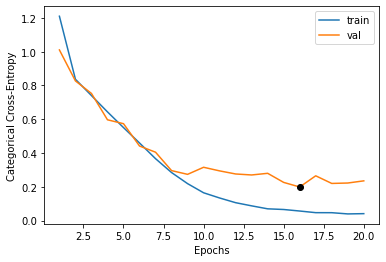

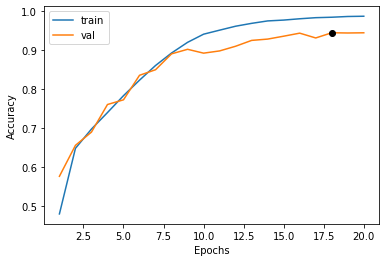

In [12]:
model_name = 'STUDENT_0.3dp_model_'
#model_name = 'WATSON_JOSIAH_final_model_'
history_file_name = model_name + 'history.hdf5'
history = load_history(save_dir, history_file_name)

train_loss = history['loss']
val_loss = history['val_loss']

plt.figure()
plt.plot(range(1,len(train_loss)+1),train_loss)
plt.plot(range(1,len(val_loss)+1),val_loss)
plt.plot(np.argmin(val_loss)+1,np.min(val_loss),'ko')
plt.xlabel('Epochs')
plt.ylabel('Categorical Cross-Entropy')
plt.legend(('train', 'val'))
print('Min Val Loss:     %0.4f, Epoch: %s' % (np.min(val_loss), np.argmin(val_loss)))

train_acc = history['acc']
val_acc = history['val_acc']

plt.figure()
plt.plot(range(1,len(train_acc)+1),train_acc)
plt.plot(range(1,len(val_acc)+1),val_acc)
plt.plot(np.argmax(val_acc)+1,np.max(val_acc),'ko')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(('train', 'val'))
print('Min Val Accuracy: %0.4f, Epoch: %s' % (np.max(val_acc), np.argmax(val_acc)))

Loading history from filepath STUDENT_0.3dp_model_history.hdf5
... loading val history
Loaded trained model from c:\Users\Brett\Documents\AFIT\courses\CSCE 823\CSCE 823 2022\06-Assignments\HW4\solution_example\WATSON_JOSIAH_HW4\saved_models\STUDENT_0.3dp_model_history.hdf5 
Min Val Loss:     0.1989, Epoch: 15
Min Val Accuracy: 0.9449, Epoch: 17


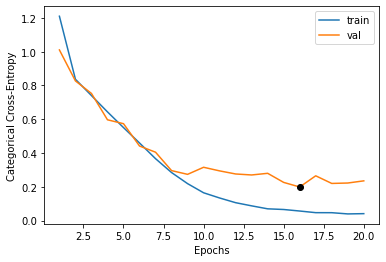

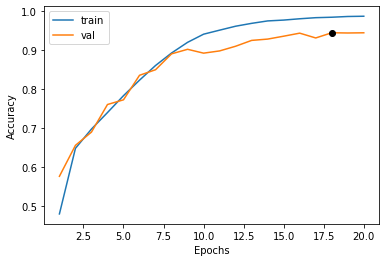

In [13]:
model_name = 'STUDENT_0.3dp_model_'
#model_name = 'WATSON_JOSIAH_final_model_'  # model_name = "WATSON_JOSIAH_final_model_history.hdf5"

history_file_name = model_name + 'history.hdf5'
#history_file_name = 'WATSON_JOSIAH_final_model_history.hdf5'

history = load_history(save_dir, history_file_name)

train_loss = history['loss']
val_loss = history['val_loss']

plt.figure()
plt.plot(range(1,len(train_loss)+1),train_loss)
plt.plot(range(1,len(val_loss)+1),val_loss)
plt.plot(np.argmin(val_loss)+1,np.min(val_loss),'ko')
plt.xlabel('Epochs')
plt.ylabel('Categorical Cross-Entropy')
plt.legend(('train', 'val'))
print('Min Val Loss:     %0.4f, Epoch: %s' % (np.min(val_loss), np.argmin(val_loss)))

train_acc = history['acc']
val_acc = history['val_acc']

plt.figure()
plt.plot(range(1,len(train_acc)+1),train_acc)
plt.plot(range(1,len(val_acc)+1),val_acc)
plt.plot(np.argmax(val_acc)+1,np.max(val_acc),'ko')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(('train', 'val'))
print('Min Val Accuracy: %0.4f, Epoch: %s' % (np.max(val_acc), np.argmax(val_acc)))

## Design Process
After doing some initial training on the student model, I ran a capacity check on the student model without the dropout layers. I found that the training plateaued after 25 epochs and the validation plateaued after 15 epochs. I found this same behavior in the student model with dropout.

I tried increasing the capacity of the time-distributed dense layer to 1024 and adding in another 256 node dense layer. However, the capacity check on this did not perform better than the first model. 

I decided to go back to the first student model and increase the dropout to 0.3. I trained this model for 40 epochs and found that the validation accuracy only got to 0.9611. Since model with a dropout of 0.2 only got to 0.9619. It did not really seem to matter which model I chose. I decided to go with the 0.2 dropout one as my final design. With 0.2 dropout, the model reached its maximum validation accuracy after 38 epochs. Thus, I decided to train the final model for 40 epochs.

## STEP 7: Final Architecture Performance Evaluation 
Train your model on all training and validation data.  Test your final model on 4-class text data.  Capture the predicted AND actual output classes for each input, so you can spot-check them later    Report standard classification metrics including loss and accuracy as well as a confusion matrix.  Perform an residuals analysis: investigate some of your network’s mistakes, given what you know about the styles of text samples provided.  Were they sections of text which were easily misclassified by a human?  Give a conjecture about why your network didn’t get them right.

In [14]:
################################################################
#--------------------- Main Student Code -----------------------

listOfFilenames = ['./textdatasets/0_bible.txt',
             './textdatasets/1_nietzsche.txt',
             './textdatasets/2_shakespeare.txt',
             './textdatasets/3_warpeace.txt']
indexfile = './indices.hdf5'
trainfile, valfile, testfile = './trainXY.hdf5', './valXY.hdf5', './testXY.hdf5'

numClasses = len(listOfFilenames)
maxlen = 40   # sentence is 40 char sequence
trainFrac, valFrac = 0.4, 0.4   # 40% training, 40% validation, 20% test


COMPUTE_IDX_MODE = False
# Load Indicies and Char List
if COMPUTE_IDX_MODE:
    indices, char_list = computeIdxs(listOfFilenames, indexfile, maxlen)
    saveIdxs(indexFile, indices, char_list) # Save indices to a file
    indices, char_list = loadIdxs(indexfile)
else:
    indices, char_list = loadIdxs(indexfile)
    

Loading './indices.hdf5'


In [15]:
READ_SPLIT_MODE = True
if READ_SPLIT_MODE:
    X_train, X_val, X_test, y_train, y_val, y_test = \
        vectAndSplit(listOfFilenames, indices, char_list, trainFrac, valFrac, maxlen)
    saveXY(trainfile, X_train, y_train)   
    saveXY(valfile, X_val, y_val)
    saveXY(testfile, X_test, y_test)
    X_train, y_train = loadXY(trainfile)
    X_val, y_val = loadXY(valfile)
    X_test, y_test = loadXY(testfile)
else:
    X_train, y_train = loadXY(trainfile)
    X_val, y_val = loadXY(valfile)
    X_test, y_test = loadXY(testfile)

X_nontest = np.concatenate((X_train,X_val),axis=0)
y_nontest = np.concatenate((y_train,y_val),axis=0)

loading:  ./textdatasets/0_bible.txt
corpus length: 4332559
number of sequences: 4332520
Vectorization processing... this could take a while...
{'\n': 0, ' ': 1, '!': 2, '"': 3, '$': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '=': 26, '?': 27, '[': 28, ']': 29, '_': 30, 'a': 31, 'b': 32, 'c': 33, 'd': 34, 'e': 35, 'f': 36, 'g': 37, 'h': 38, 'i': 39, 'j': 40, 'k': 41, 'l': 42, 'm': 43, 'n': 44, 'o': 45, 'p': 46, 'q': 47, 'r': 48, 's': 49, 't': 50, 'u': 51, 'v': 52, 'w': 53, 'x': 54, 'y': 55, 'z': 56, '\xa0': 57, '¤': 58, '¦': 59, '©': 60, 'ª': 61, '«': 62, '»': 63, '¿': 64, 'ã': 65, 'ï': 66, '†': 67}
 part 1 of 2
433253  of  4332520  completed
866505  of  4332520  completed
1299757  of  4332520  completed
1733009  of  4332520  completed
2166261  of  4332520  completed
2599513  of  4332520  completed
3032765  of  4332520  completed
3466017  of  4

In [16]:
model_epoch_training_iterations = 4    #the bigger your text corpus, the smaller you can make this


save_dir = os.path.join(os.getcwd(), 'saved_models')
TRAIN_MODE = True   #SET TO FALSE BEFORE SUBMITTING YOUR ASSIGNMENT!!!
CONTINUE_TRAINING = False
if TRAIN_MODE:
    model_name = 'WATSON_JOSIAH_final_model_'
    if CONTINUE_TRAINING:
        last_epoch = 4
        current_model_file_name = model_name + str(last_epoch) + '.h5'
        final = load_model(save_dir=save_dir, model_file_name=current_model_file_name)
    else:
        last_epoch = 0
        final = student_build_model(len(char_list), numClasses)
        plot_model(final, show_shapes=True, to_file='student.png')
    
    final, history = student_train_net(final, X_nontest, y_nontest, 
                      start_iteration=last_epoch+1,
                      training_iterations=model_epoch_training_iterations,
                      modelName = model_name,
                      save_all_model_iterations=True)
else:  # load a model from a file
    # decide which iteration of the trained model you want to explore
    model_name = 'WATSON_JOSIAH_final_model'
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    current_model_file_name = model_name + '.h5'
    final = load_model(save_dir=save_dir, model_file_name=current_model_file_name)
    

Build model...
model is made
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 40, 512)           1189888   
_________________________________________________________________
lstm_3 (LSTM)                (None, 40, 512)           2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 256)           131328    
_________________________________________________________________
activation_2 (Activation)    (None, 40, 256)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)      

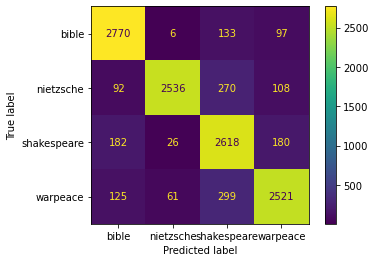

In [17]:
confMat = test_model(final, X_test, y_test)
class_labels = ['bible', 'nietzsche', 'shakespeare', 'warpeace']

#custom function not working...
# plot_confusion_matrix(confMat, class_labels, title='Confusion matrix',
#                           filename = 'Confusion_Matrix.png')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=class_labels)

disp.plot()


In [18]:
loss, acc = final.evaluate(X_test, y_test)
print('Final Test Loss:       %0.4f' % loss)
print('Final Test Accuracy:   %0.4f' % acc)

376/376 [==============================] - 4s 9ms/step - loss: 0.3663 - accuracy: 0.8687
Final Test Loss:       0.3663
Final Test Accuracy:   0.8687
